In [1]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from scipy import stats
import itertools
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import plotTimeseries
import os
import pandas as pd
from pyspark.sql import Window
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch, Rectangle, Circle
from wordcloud import WordCloud

sns.set(font_scale=1.5)
sns.set_style('ticks')
%load_ext autoreload
%autoreload 2

#spark = SparkSession.builder.config("spark.driver.bindAddress","192.168.1.196").getOrCreate()
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/11/06 10:21:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Novelty peaks overlap across resource

In [ ]:
year = 2005
resultsReal,resultsShuffled = [],[]
data = (spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/noveltyCorrelation/evidenceLink=direct/pairs")       
        .filter((F.col("realYearA")>=year)&(F.col("realYearB")>=year)).toPandas())
for s1, s2 in itertools.product(data.datasourceIdA.unique(), data.datasourceIdA.unique()):
    # real
    x=data[(data.datasourceIdA==s1)&(data.datasourceIdB==s2)][["realYearA","realYearB"]].dropna().realYearA
    y=data[(data.datasourceIdA==s1)&(data.datasourceIdB==s2)][["realYearA","realYearB"]].dropna().realYearB
    try:
        rvalue, pvalue = stats.pearsonr(x, y)
        resultsReal.append([s1, s2,round(rvalue,2), round(pvalue,3), len(x)])
    except ValueError:
        resultsReal.append([s1, s2, None, None, len(x)])
    # shuffled
    x=data[(data.datasourceIdA==s1)&(data.datasourceIdB==s2)][["shuffledYearA","shuffledYearB"]].dropna().shuffledYearA
    y=data[(data.datasourceIdA==s1)&(data.datasourceIdB==s2)][["shuffledYearA","shuffledYearB"]].dropna().shuffledYearB
    try:
        rvalue, pvalue = stats.pearsonr(x, y)
        resultsShuffled.append([s1, s2,round(rvalue,2), round(pvalue,3), len(x)])
    except ValueError:
        resultsShuffled.append([s1, s2, None, None, len(x)])
resultsReal = pd.DataFrame(resultsReal, columns=["datasourceIdA","datasourceIdB","r","p","n"])
resultsShuffled = pd.DataFrame(resultsShuffled, columns=["datasourceIdA","datasourceIdB","r","p","n"])
resultsReal.to_csv("../results/23.06/correlation{}.csv".format(year), index=False)
resultsShuffled.to_csv("../results/23.06/correlationShuffled{}.csv".format(year), index=False)

In [ ]:
# correlation clustermap
year = 2005
data = pd.read_csv("../results/23.06/correlation{}.csv".format(year)).copy()
data = data[(data["p"]<=0.05)]
data = (data
        .pivot(index="datasourceIdA", columns="datasourceIdB", values="r")
        .merge(plotTimeseries.getDatatypeForDatasource(output="dataframe").rename(columns={"datasourceId":"datasourceIdA"}), on="datasourceIdA", how="inner")
        .replace(plotTimeseries.getDatasourceToName(output="dict"))
        .rename(columns=plotTimeseries.getDatasourceToName(output="dict"))
        .set_index("datasourceIdA")
        .replace(plotTimeseries.getDatatypeToName(output="dict"))
        .rename(columns={"datatypeId":"Category"})
)
categories = data.pop("Category")
row_colors = categories.map(plotTimeseries.getDatatypeToColour(by="label"))
plt.figure(figsize=(15,15))
sns.set(font_scale=1.5, style="ticks")
ax = sns.clustermap(data.fillna(0), lw=1, cmap="Blues", square=True, vmin=0, vmax=1, row_colors=row_colors, cbar_pos=(0, .35, .03, .4), cbar_kws={"label":"Pearson correlation coefficient"})
ax.ax_row_dendrogram.set_visible(False)
ax.ax_col_dendrogram.set_visible(False)
ax.ax_heatmap.set_xlabel("")
ax.ax_heatmap.set_ylabel("")
plt.savefig("../results/23.06/plots/correlations.png", dpi=300, bbox_inches="tight")

In [ ]:
# correlation heatmap annotated
data = pd.read_csv("../results/23.06/correlation{}.csv".format(year)).copy()
data["annot"] = data.apply(lambda row: "r={}\np={}\nN={}".format(row.r, row.p, row.n), axis=1)
plt.figure(figsize=(30,30))
ax = sns.heatmap(data.pivot(index="datasourceIdA", columns="datasourceIdB", values="r"), 
            annot=data.pivot(index="datasourceIdA", columns="datasourceIdB", values="annot").fillna(""), fmt="",
            lw=1, cbar=False, cmap="Blues", vmin=0, vmax=1)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("../results/23.06/plots/correlations_annot.png", dpi=300)

In [ ]:
# correlation heatmap for shuffled peaks annotated
data = pd.read_csv("../results/23.06/correlationShuffled{}.csv".format(year)).copy()
data["annot"] = data.apply(lambda row: "r={}\np={}\nN={}".format(row.r, row.p, row.n), axis=1)
plt.figure(figsize=(30,30))
ax = sns.heatmap(data.pivot(index="datasourceIdA", columns="datasourceIdB", values="r"), 
            annot=data.pivot(index="datasourceIdA", columns="datasourceIdB", values="annot").fillna(""), fmt="",
            lw=1, cbar=False, cmap="Blues", vmin=0, vmax=1)
ax.set_xlabel("")
ax.set_ylabel("")
plt.savefig("../results/23.06/plots/correlationsShuffled_annot.png", dpi=300)

Bell plots

In [4]:
yearsRange = "2020-2022"
data = pd.read_csv("/Users/mariaf/TargetEngine/results/23.06/noveltyBenchmark/bells/years="+yearsRange).replace(plotTimeseries.getDatatypeToName(output="dict"))
data["years"] = data.apply(lambda row: row.years.replace("sum(","").replace("-","−").replace(",",", ")[:-1], axis=1)
data = data[(data.datatypeId!="Pre-clinical phase")&(data.datatypeId!="Known drug")]
datatypes = ["Human genetic data", "Literature", "Animal model", "Affected pathway", "RNA expression","Clinical phase I/II","Clinical phase III","Clinical phase IV"][::-1]

In [ ]:
plt.figure()
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.5, style="ticks")
for datatypeId in datatypes:
    sns.lineplot(data=data[data.datatypeId==datatypeId], x="years", y="%withPeak", color="w", lw=10, legend=False, ax=ax, alpha=1)
    sns.lineplot(data=data[(data.datatypeId==datatypeId)], x="years", y="%withPeak", color=plotTimeseries.getDatatypeToColour(by="label")[datatypeId], lw=7, legend=False, ax=ax, alpha=1, label=datatypeId)        

ax.set_ylabel("% of targets with novelty peak")
ax.set_xlabel("Peak year − Approval year")
ax.set_ylim(-3,100)
ax.grid(axis="y", lw=.5)
#ax.set_title("{} novel drug targets".format(yearsRange), fontweight="bold")
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=40, ha="right")
ax.axvline(x=6, color="k", linestyle="--", lw=1)
sns.despine()
plt.savefig("../results/23.06/plots/bells/{}.png".format(yearsRange), dpi=300, bbox_inches="tight")

Cascade plots

In [ ]:
data = spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/noveltyBenchmark/cascadesBoxplot").orderBy("years").select("datatypeId","window","years").toPandas()
for datatypeId in data.datatypeId.unique():
    sns.set(font_scale=1.7, style="ticks")
    fig, ax = plt.subplots(figsize=(5,5))
    sns.boxplot(data=data[data.datatypeId==datatypeId], x="years", y="window", zorder=1, color=plotTimeseries.getDatatypeToColour()[datatypeId], fliersize=0, boxprops={"edgecolor":"w"}, medianprops={"color":"w"})
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right",va="top")
    ax.set_xlabel("Drug approval year")
    ax.set_ylabel("Peak year − Approval year")
    ax.set_title(plotTimeseries.getDatatypeToName(output="dict")[datatypeId]+" peak")
    ax.set_ylim(25,-25)
    ax.grid(axis="y", lw=.5, zorder=0)
    ax.axhline(y=0, lw=1, linestyle="--", color="k", zorder=2)
    sns.despine()
    plt.savefig("../results/23.06/plots/cascades/{}.png".format(datatypeId.replace("/","-")), dpi=300, bbox_inches="tight")

Novel drug targets since 2000

In [ ]:
(spark.read.option("header", "true").csv("/Users/mariaf/ChEMBL/CHEMBL_34/drugs.csv")
  .join(spark.read.parquet("/Users/mariaf/OT_platform/23.06/evidence/sourceId=chembl").filter(F.col("clinicalPhase")==4).select("drugId","targetId","diseaseId").distinct(), "drugId", "left")
  .filter(F.col("targetId").isNotNull()&(F.col("firstApprovalYear").isNotNull()))
  .withColumn("minApprovalYear", F.min("firstApprovalYear").over(Window.partitionBy("targetId")))
  .filter(F.col("minApprovalYear")==F.col("firstApprovalYear"))
  .select("drugId","drug","targetId","diseaseId",F.col("firstApprovalYear").alias("approvalYear")).distinct()
).write.parquet("../data/novelDrugTargets/novelDrugTargets")

Timestamps

In [ ]:
data = (spark.read.parquet("../results/23.06/reportEvidenceDirectDated/")
        .join(spark.createDataFrame(plotTimeseries.getDatasourceToName(), schema=["datasourceId", "datasourceName"]), "datasourceId", "left")
        .join(spark.createDataFrame(plotTimeseries.getDatatypeForDatasource(), schema=["datasourceId", "datatypeId"]), "datasourceId", "left")
        .join(spark.createDataFrame(plotTimeseries.getDatatypeToName(), schema=["datatypeId", "datatypeName"]), "datatypeId", "left")
        .groupby("datasourceName", "datatypeName").agg(F.sum("nAll").alias("Evidence"))
        .withColumnRenamed("datasourceName","Source")
).toPandas()
data["sortedDatasourceName"] = data.Source.astype("category")
data["sortedDatasourceName"] = data.sortedDatasourceName.cat.set_categories(plotTimeseries.datasourceOrder)
data = data.sort_values("sortedDatasourceName").drop("sortedDatasourceName", axis=1)
data.sum()

In [ ]:
plt.figure(figsize=(9, 6))
sns.set(font_scale=1.5)
sns.set_style('ticks')
plt.rcParams['legend.handlelength'] = 1.2
plt.rcParams['legend.handleheight'] = 1.51

data = (spark.read.parquet("../results/23.06/reportEvidenceDirectDated/")
        .filter((F.col("year")<=2023)).select("datasourceId","year")
        .join(spark.createDataFrame(plotTimeseries.getDatasourceToName(), schema=["datasourceId", "datasourceName"]), "datasourceId", "left")
        .join(spark.createDataFrame(plotTimeseries.getDatatypeForDatasource(), schema=["datasourceId", "datatypeId"]), "datasourceId", "left")
        .join(spark.createDataFrame(plotTimeseries.getDatatypeToName(), schema=["datatypeId", "datatypeName"]), "datatypeId", "left")
        .toPandas())
data["sortedDatasourceName"] = data.datasourceName.astype("category")
data["sortedDatasourceName"] = data.sortedDatasourceName.cat.set_categories(plotTimeseries.datasourceOrder)
data = data.sort_values("sortedDatasourceName").drop("sortedDatasourceName", axis=1)

ax = sns.boxplot(x="datasourceName", y="year", hue="datatypeName", data=data.replace({"Known drug":"Clinical"}), fliersize=0, width=.6, 
                 boxprops={"edgecolor":"w"}, medianprops={"color":"k"},
                 palette=plotTimeseries.getDatatypeToColour(by="label"))
ax.set_ylim(1950,2024.5)
ax.set_xlabel("")
ax.set_ylabel("Year of evidence timestamp")
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis="y", lw=.5)
ax.legend(title="Category:", fancybox=False, frameon=True, facecolor="w", edgecolor="k", framealpha=1, fontsize=15, title_fontsize=15)
plt.savefig("../results/23.06/plots/timestampsBoxplot.png", dpi=300, bbox_inches="tight", transparent=True)

In [ ]:
data = (spark.read.parquet("../results/23.06/reportEvidenceDirectDated/")
        .join(spark.createDataFrame(plotTimeseries.getDatasourceToName(), schema=["datasourceId", "datasourceName"]), "datasourceId", "left")
        .groupby("datasourceName").agg(F.sum("nDated").alias("Dated evidence"))
        .withColumnRenamed("datasourceName","Source")
).toPandas()
data["sortedDatasourceName"] = data.Source.astype("category")
data["sortedDatasourceName"] = data.sortedDatasourceName.cat.set_categories(plotTimeseries.datasourceOrder)
data = data.sort_values("sortedDatasourceName").drop("sortedDatasourceName", axis=1)
data

Temporal profiles for case example

In [ ]:
# evidence
case = (spark.read.parquet("../results/23.06/evidenceIndirectDated/").filter((F.col("diseaseId")=="MONDO_0004979")&(F.col("targetId")=="ENSG00000145777"))
        .join(spark.createDataFrame([["chembl","ChEMBL"],["ot_genetics_portal","OT Genetics"],["europepmc","Europe PMC"]], schema=["datasourceId","datasourceName"]), "datasourceId","left")
 .select("datasourceName","year","score")
).toPandas()

sns.set(font_scale=1.7, style="ticks")
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=case, x="year", y="score", hue="datasourceName", palette={"Europe PMC":plotTimeseries.getDatatypeToColour()["literature"],
                                                                               "OT Genetics":plotTimeseries.getDatatypeToColour()["genetic_association"],
                                                                               "ChEMBL":plotTimeseries.getDatatypeToColour()["known_drug"]}, hue_order=["Europe PMC","OT Genetics","ChEMBL"], s=500, alpha=.4, ax=ax)
ax.set_xlim(2000,2024)
ax.set_ylim(0,1.05)
ax.set_xlabel("")
ax.set_ylabel("Score")
ax.set_title("Evidence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
ax.legend(frameon=False, loc="upper left")
sns.despine()
plt.savefig("../results/23.06/plots/case/evidence.png", dpi=300, bbox_inches="tight")

In [ ]:
# score
sns.set(font_scale=1.7, style="ticks")
data = (spark.read.parquet("../results/23.06/associationByDatasourceIndirectOverYears/").filter((F.col("diseaseId")=="MONDO_0004979")&(F.col("targetId")=="ENSG00000145777"))
.join(spark.createDataFrame([["chembl","ChEMBL"],["ot_genetics_portal","OT Genetics"],["europepmc","Europe PMC"]], schema=["datasourceId","datasourceName"]), "datasourceId","left")
.toPandas())

fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(data=data, x="year", y="score", hue="datasourceName", palette={"Europe PMC":plotTimeseries.getDatatypeToColour()["literature"],
                                                                               "OT Genetics":plotTimeseries.getDatatypeToColour()["genetic_association"],
                                                                               "ChEMBL":plotTimeseries.getDatatypeToColour()["known_drug"]}, hue_order=["Europe PMC","OT Genetics","ChEMBL"], lw=3)
ax.set_xlim(2000,2023)
ax.set_ylim(0,1.05)
ax.set_xlabel("")
ax.set_ylabel("Score")
ax.set_title("Association")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['legend.handleheight'] = 1.51
ax.legend(frameon=False, loc="upper left")
sns.despine()
plt.savefig("../results/23.06/plots/case/score.png", dpi=300, bbox_inches="tight")

In [ ]:
# novelty
sns.set(font_scale=1.7, style="ticks")
data = (spark.read.parquet("../results/23.06/associationByDatasourceIndirectOverYears/").filter((F.col("diseaseId")=="MONDO_0004979")&(F.col("targetId")=="ENSG00000145777"))
.join(spark.createDataFrame([["chembl","ChEMBL"],["ot_genetics_portal","OT Genetics"],["europepmc","Europe PMC"]], schema=["datasourceId","datasourceName"]), "datasourceId","left")
.toPandas())

fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(data=data, x="year", y="novelty", hue="datasourceName", palette={"Europe PMC":plotTimeseries.getDatatypeToColour()["literature"],
                                                                               "OT Genetics":plotTimeseries.getDatatypeToColour()["genetic_association"],
                                                                               "ChEMBL":plotTimeseries.getDatatypeToColour()["known_drug"]},  hue_order=["Europe PMC","OT Genetics","ChEMBL"], lw=6)
ax.set_xlim(2000,2023)
ax.set_ylim(0,1.05)
ax.set_xlabel("")
ax.set_ylabel("Score")
ax.set_title("Novelty")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['legend.handleheight'] = 1.51
ax.legend(frameon=False, loc="upper left")
sns.despine()
plt.savefig("../results/23.06/plots/case/novelty.png", dpi=300, bbox_inches="tight")

In [ ]:
# evidence+novelty
evidence = (spark.read.parquet("../results/23.06/evidenceIndirectDated/").filter((F.col("diseaseId")=="MONDO_0004979")&(F.col("targetId")=="ENSG00000145777"))
        .join(spark.createDataFrame([["chembl","ChEMBL evidence"],["ot_genetics_portal","OT Genetics evidence"],["europepmc","Europe PMC evidence"]], schema=["datasourceId","datasourceName"]), "datasourceId","left")
 .select("datasourceName","year","score")
).toPandas()
novelty = (spark.read.parquet("../results/23.06/associationByDatasourceIndirectOverYears/").filter((F.col("diseaseId")=="MONDO_0004979")&(F.col("targetId")=="ENSG00000145777"))
.join(spark.createDataFrame([["chembl","ChEMBL novelty"],["ot_genetics_portal","OT Genetics novelty"],["europepmc","Europe PMC novelty"]], schema=["datasourceId","datasourceName"]), "datasourceId","left")
.toPandas())

sns.set(font_scale=1.7, style="ticks")
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(data=evidence, x="year", y="score", hue="datasourceName", palette={"Europe PMC evidence":plotTimeseries.getDatatypeToColour()["literature"],
                                                                               "OT Genetics evidence":plotTimeseries.getDatatypeToColour()["genetic_association"],
                                                                               "ChEMBL evidence":plotTimeseries.getDatatypeToColour()["known_drug"]}, hue_order=["Europe PMC evidence","OT Genetics evidence","ChEMBL evidence"], s=500, alpha=.4, ax=ax)
sns.lineplot(data=novelty, x="year", y="novelty", hue="datasourceName", palette={"Europe PMC novelty":"w",
                                                                               "OT Genetics novelty":"w",
                                                                               "ChEMBL novelty":"w"}, lw=10, legend=False)
sns.lineplot(data=novelty, x="year", y="novelty", hue="datasourceName", palette={"Europe PMC novelty":plotTimeseries.getDatatypeToColour()["literature"],
                                                                               "OT Genetics novelty":plotTimeseries.getDatatypeToColour()["genetic_association"],
                                                                               "ChEMBL novelty":plotTimeseries.getDatatypeToColour()["known_drug"]},  hue_order=["Europe PMC novelty","OT Genetics novelty","ChEMBL novelty"], lw=6)

ax.set_xlim(2000,2024)
ax.set_ylim(0,1.05)
ax.set_xlabel("")
ax.set_ylabel("Score")
ax.set_title("TSLP + asthma")
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5))
ax.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.savefig("../results/23.06/plots/case/evidence+novelty.png", dpi=300, bbox_inches="tight")

GE for approvals in Rusina 2023 from OT platform 23.02

In [ ]:
approvalsRusinaGE = pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")#[["drugId","therapeuticArea","yearApproval","hasAnyGE","targetType","diseaseType","brandDrugName"]]


In [ ]:
pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")[["drugId","brandDrugName","therapeuticArea","yearApproval"]].to_csv("../data/approvals.tsv", index=False, sep="\t")
(spark.read.option("header","true").option("sep","\t").csv("../data/approvals.tsv") # Rusina Sup. Table
  .withColumnRenamed("drugId", "drugIds")
  .withColumn("drugId", F.explode_outer(F.split("drugIds", ", ")))
  .join(spark.read.parquet("/Users/mariaf/OT_platform/23.02/evidence/sourceId=chembl").select("diseaseId","targetId","drugId"), ["drugId"], "left")
  .groupby("drugIds","brandDrugName","therapeuticArea","yearApproval").agg(F.collect_set("diseaseId").alias("diseaseIds"), F.collect_set("targetId").alias("targetIds"))
  .withColumnRenamed("drugIds", "drugId")
 ).toPandas().to_csv("approvalsAutomaticPair.tsv", sep="\t", index=False)

Automatic GE extraction from OT_platform 23.02

In [ ]:
approvalsAutomaticGE = (
    # phase IV -> direct target-disease associations since 2013
    spark.read.parquet("/Users/mariaf/OT_platform/23.02/evidence/sourceId=chembl").filter(F.col("clinicalPhase")==4)
    .select("drugId", "diseaseId", "targetId", F.split("studyStartDate", "-").getItem(0).alias("studyStartYear"))
    .filter(F.col("studyStartYear")>=2013)
    # indirect GE
    .join(spark.read.parquet("/Users/mariaf/OT_platform/23.02/evidence/").select("datasourceId","diseaseId","targetId")
          .filter(~F.col("datasourceId").isin(["chembl","europepmc"])), 
          ["diseaseId","targetId"], "left")
)
print("drugId: ", approvalsAutomaticGE.select("drugId").distinct().count())
print("drugId with GE: ", approvalsAutomaticGE.filter(F.col("datasourceId").isNotNull()).select("drugId").distinct().count())
print("% drugId with GE: ", approvalsAutomaticGE.filter(F.col("datasourceId").isNotNull()).select("drugId").distinct().count()/approvalsAutomaticGE.select("drugId").distinct().count())

print("targetId: ", approvalsAutomaticGE.select("targetId").distinct().count())
print("targetId with GE: ", approvalsAutomaticGE.filter(F.col("datasourceId").isNotNull()).select("targetId").distinct().count())
print("% targetId with GE: ", approvalsAutomaticGE.filter(F.col("datasourceId").isNotNull()).select("targetId").distinct().count()/approvalsAutomaticGE.select("targetId").distinct().count())

print("targetId-diseaseId: ", approvalsAutomaticGE.select("targetId","diseaseId").distinct().count())
print("targetId-diseaseId with GE: ", approvalsAutomaticGE.filter(F.col("datasourceId").isNotNull()).select("targetId","diseaseId").distinct().count())
print("% targetId-diseaseId with GE: ", approvalsAutomaticGE.filter(F.col("datasourceId").isNotNull()).select("targetId","diseaseId").distinct().count()/approvalsAutomaticGE.select("targetId","diseaseId").distinct().count())

approvalsAutomaticGE = approvalsAutomaticGE.select("drugId","studyStartYear","datasourceId").distinct().toPandas()
approvalsAutomaticGE["studyStartYear"] = approvalsAutomaticGE.apply(lambda x: int(x.studyStartYear), axis=1)

Rusina section

In [ ]:
approvalsRusinaIndirectGE = pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")[["drugId","therapeuticArea","yearApproval","hasAnyGE","targetType","diseaseType"]]
approvalsRusinaDirectGE = pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")[["drugId","therapeuticArea","yearApproval","hasAnyGE","targetType","diseaseType"]]
approvalsRusinaGE = pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")[["drugId","therapeuticArea","yearApproval","hasAnyGE","targetType","diseaseType"]]
approvalsRusinaGE["therapeuticArea"] = approvalsRusinaGE.apply(lambda row: "oncology" if row.therapeuticArea == "Oncology" else "non-oncology", axis=1)

results = (
    # automatic GE extraction from platform 23.02    
    #approvalsAutomaticGE.groupby("studyStartYear").count().drugId.reset_index().rename(columns={"drugId":"automaticDrugId","studyStartYear":"year"})
    #.merge(approvalsAutomaticGE[approvalsAutomaticGE.datasourceId.notnull()].groupby("studyStartYear").count().drugId.reset_index().rename(columns={"drugId":"automaticGE", "studyStartYear":"year"}), on="year", how="left")
    
    # Rusina approvals
    approvalsRusinaIndirectGE.groupby(["yearApproval"]).count()[["drugId"]].reset_index().rename(columns={"drugId":"Approvals","yearApproval":"year"})
    
    # Rusina approvals supported by indirect GE linking original/interactor target and original/related disease
    .merge(approvalsRusinaGE[(approvalsRusinaGE.hasAnyGE==True)].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Any indirect GE","yearApproval":"year"}), on="year", how="left")      
    # Rusina approvals supported by indirect GE linking original target and original disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaIndirectGE.hasAnyGE==True)&(approvalsRusinaIndirectGE.targetType=="Original")&(approvalsRusinaIndirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"%Indirect GE between original target and original disease","yearApproval":"year"}), on="year", how="left")
    # Rusina approvals supported by indirect GE linking original target and original/related disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaIndirectGE.hasAnyGE==True)&(approvalsRusinaIndirectGE.targetType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Indirect GE between original target and original/related disease","yearApproval":"year"}), on="year", how="left")
    # Rusina approvals supported by indirect GE linking original/interactor target and original disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaIndirectGE.hasAnyGE==True)&(approvalsRusinaIndirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Indirect GE between original/interacting target and original disease","yearApproval":"year"}), on="year", how="left")    
    
    # Rusina approvals supported by direct GE linking original/interactor target and original/related disease
    .merge(approvalsRusinaGE[(approvalsRusinaDirectGE.hasAnyGE==True)].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"%Direct GE between original/interacting target and original/related disease","yearApproval":"year"}), on="year", how="left")      
    # Rusina approvals supported by direct GE linking original target and original disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaDirectGE.hasAnyGE==True)&(approvalsRusinaDirectGE.targetType=="Original")&(approvalsRusinaDirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"%Direct GE between original target and original disease","yearApproval":"year"}), on="year", how="left")
    # Rusina approvals supported by direct GE linking original target and original/related disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaDirectGE.hasAnyGE==True)&(approvalsRusinaDirectGE.targetType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Direct GE between original target and original/related disease","yearApproval":"year"}), on="year", how="left")
    # Rusina approvals supported by direct GE linking original/interactor target and original disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaDirectGE.hasAnyGE==True)&(approvalsRusinaDirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Direct GE between original/interacting target and original disease","yearApproval":"year"}), on="year", how="left")    
)
#results["%automaticGE"] = results["automaticGE"]/results["automaticDrugId"]

results["%Any indirect GE"] = results["Indirect GE between original/interacting target and original/related disease"]/results["Approvals"]
# results["%Indirect GE between original target and original disease"] = results["Indirect GE between original target and original disease"]/results["Approvals"]
# results["%Indirect GE between original target and original/related disease"] = results["Indirect GE between original target and original/related disease"]/results["Approvals"]
# results["%Indirect GE between original/interacting target and original disease"] = results["Indirect GE between original/interacting target and original disease"]/results["Approvals"]

# results["%Direct GE between original/interacting target and original/related disease"] = results["Direct GE between original/interacting target and original/related disease"]/results["Approvals"]
# results["%Direct GE between original target and original disease"] = results["Direct GE between original target and original disease"]/results["Approvals"]
# results["%Direct GE between original target and original/related disease"] = results["Direct GE between original target and original/related disease"]/results["Approvals"]
# results["%Direct GE between original/interacting target and original disease"] = results["Direct GE between original/interacting target and original disease"]/results["Approvals"]


# ax = plt.figure().add_subplot()

# sns.lineplot(data=results, x="year", y="%Indirect GE between original/interacting target and original/related disease", marker=".", markersize=10, color="g", 
#              label="%Indirect GE between original/interacting target and original/related disease", ax=ax)
# sns.lineplot(data=results, x="year", y="Indirect GE between original/interacting target and original disease", marker=".", markersize=10, color="orange", ax=ax, 
#              label="Indirect GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="Indirect GE between original target and original/related disease", marker=".", markersize=10, color="purple", ax=ax, 
#              label="%Indirect GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="%Indirect GE between original target and original disease", marker=".", markersize=10, color="b", ax=ax, 
#              label="%Indirect GE between original target and original disease")

# sns.lineplot(data=results, x="year", y="%Direct GE between original/interacting target and original/related disease", marker=".", markersize=10, color="g", 
#              label="%Direct GE between original/interacting target and original/related disease", ax=ax, linestyle="--")
# sns.lineplot(data=results, x="year", y="Direct GE between original/interacting target and original disease", marker=".", markersize=10, color="orange", ax=ax, linestyle="--", 
#              label="Direct GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="Direct GE between original target and original/related disease", marker=".", markersize=10, color="purple", ax=ax, linestyle="--", 
#              label="%Direct GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="%Direct GE between original target and original disease", marker=".", markersize=10, color="b", ax=ax, linestyle="--", 
#              label="%Direct GE between original target and original disease")

# #sns.lineplot(data=results, x="year", y="%automaticGE", marker=".", markersize=10, color="r", label="Automatic GE", ax=ax)
# ax.set_ylim(0,1)
# ax.set_xlim(2013,2023)
# ax.set_ylabel("% Approvals")
# ax.set_xlabel("Approval year")
# leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=0)
# #plt.savefig("../results/23.02/plots/approvals.png", dpi=300, bbox_inches="tight")

In [ ]:
approvalsRusinaIndirectGE = pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")[["drugId","therapeuticArea","yearApproval","hasAnyGE","targetType","diseaseType"]]
approvalsRusinaDirectGE = pd.read_excel("/Users/mariaf/TargetEngine/data/approvals/26125730.xlsx")[["drugId","therapeuticArea","yearApproval","hasAnyGE","targetType","diseaseType"]]
#approvalsRusinaGE["therapeuticArea"] = approvalsRusinaGE.apply(lambda row: "oncology" if row.therapeuticArea == "Oncology" else "non-oncology", axis=1)

results = (
    
    # Rusina approvals
    approvalsRusinaIndirectGE.groupby(["yearApproval"]).count()[["drugId"]].reset_index().rename(columns={"drugId":"Approvals","yearApproval":"year"})
    
    # Rusina approvals supported by direct GE linking original target and original disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaDirectGE.hasAnyGE==True)&(approvalsRusinaDirectGE.targetType=="Original")&(approvalsRusinaDirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Direct GE between original target and original disease","yearApproval":"year"}), on="year", how="left")
    
    # Rusina approvals supported by indirect GE linking original target and original disease
    .merge(approvalsRusinaIndirectGE[(approvalsRusinaIndirectGE.hasAnyGE==True)&(approvalsRusinaIndirectGE.targetType=="Original")&(approvalsRusinaIndirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
           .rename(columns={"drugId":"Indirect GE between original target and original disease","yearApproval":"year"}), on="year", how="left")
    
#     # Rusina approvals supported by indirect GE linking original/interactor target and original/related disease
#     .merge(approvalsRusinaGE[(approvalsRusinaIndirectGE.hasAnyGE==True)].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
#            .rename(columns={"drugId":"Indirect GE between original/interacting target and original/related disease","yearApproval":"year"}), on="year", how="left")      
#     # Rusina approvals supported by indirect GE linking original target and original/related disease
#     .merge(approvalsRusinaIndirectGE[(approvalsRusinaIndirectGE.hasAnyGE==True)&(approvalsRusinaIndirectGE.targetType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
#            .rename(columns={"drugId":"Indirect GE between original target and original/related disease","yearApproval":"year"}), on="year", how="left")
#     # Rusina approvals supported by indirect GE linking original/interactor target and original disease
#     .merge(approvalsRusinaIndirectGE[(approvalsRusinaIndirectGE.hasAnyGE==True)&(approvalsRusinaIndirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
#            .rename(columns={"drugId":"Indirect GE between original/interacting target and original disease","yearApproval":"year"}), on="year", how="left")    
    
#     # Rusina approvals supported by direct GE linking original/interactor target and original/related disease
#     .merge(approvalsRusinaGE[(approvalsRusinaDirectGE.hasAnyGE==True)].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
#            .rename(columns={"drugId":"Direct GE between original/interacting target and original/related disease","yearApproval":"year"}), on="year", how="left")      
    
#     # Rusina approvals supported by direct GE linking original target and original/related disease
#     .merge(approvalsRusinaIndirectGE[(approvalsRusinaDirectGE.hasAnyGE==True)&(approvalsRusinaDirectGE.targetType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
#            .rename(columns={"drugId":"Direct GE between original target and original/related disease","yearApproval":"year"}), on="year", how="left")
#     # Rusina approvals supported by direct GE linking original/interactor target and original disease
#     .merge(approvalsRusinaIndirectGE[(approvalsRusinaDirectGE.hasAnyGE==True)&(approvalsRusinaDirectGE.diseaseType=="Original")].groupby(["yearApproval"]).count()[["drugId"]].reset_index()
#            .rename(columns={"drugId":"Direct GE between original/interacting target and original disease","yearApproval":"year"}), on="year", how="left")    
)
#results["%automaticGE"] = results["automaticGE"]/results["automaticDrugId"]

results["%Direct GE between original target and original disease"] = results["Direct GE between original target and original disease"]/results["Approvals"]
results["%Indirect GE between original target and original disease"] = results["Indirect GE between original target and original disease"]/results["Approvals"]

# results["%Indirect GE between original/interacting target and original/related disease"] = results["Indirect GE between original/interacting target and original/related disease"]/results["Approvals"]
# results["%Indirect GE between original target and original/related disease"] = results["Indirect GE between original target and original/related disease"]/results["Approvals"]
# results["%Indirect GE between original/interacting target and original disease"] = results["Indirect GE between original/interacting target and original disease"]/results["Approvals"]

# results["%Direct GE between original/interacting target and original/related disease"] = results["Direct GE between original/interacting target and original/related disease"]/results["Approvals"]
# results["%Direct GE between original target and original/related disease"] = results["Direct GE between original target and original/related disease"]/results["Approvals"]
# results["%Direct GE between original/interacting target and original disease"] = results["Direct GE between original/interacting target and original disease"]/results["Approvals"]


ax = plt.figure().add_subplot()

# sns.lineplot(data=results, x="year", y="Indirect GE between original/interacting target and original disease", marker=".", markersize=10, color="orange", ax=ax, 
#              label="Indirect GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="Indirect GE between original target and original/related disease", marker=".", markersize=10, color="purple", ax=ax, 
#              label="%Indirect GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="%Indirect GE between original target and original disease", marker=".", markersize=10, color="b", ax=ax, 
#              label="%Indirect GE between original target and original disease")

# sns.lineplot(data=results, x="year", y="Direct GE between original/interacting target and original/related disease", marker=".", markersize=10, color="g", 
#              label="Direct GE between original/interacting target and original/related disease", ax=ax, linestyle="--")
# sns.lineplot(data=results, x="year", y="Direct GE between original/interacting target and original disease", marker=".", markersize=10, color="orange", ax=ax, linestyle="--", 
#              label="Direct GE between original/interacting target and original disease")
# sns.lineplot(data=results, x="year", y="Direct GE between original target and original/related disease", marker=".", markersize=10, color="purple", ax=ax, linestyle="--", 
#              label="Direct GE between original/interacting target and original disease")

sns.lineplot(data=results, x="year", y="%Direct GE between original target and original disease", marker=".", markersize=10, color=blue, ax=ax, linestyle="--", 
             label="%Direct GE between original target and original disease")
sns.lineplot(data=results, x="year", y="%Indirect GE between original target and original disease", marker=".", markersize=10, color=blue, ax=ax, linestyle="-", 
             label="%Indirect GE between original target and original disease")

ax.set_ylim(0,1)
ax.set_xlim(2013,2023)
ax.set_ylabel("% Approvals")
ax.set_xlabel("Approval year")
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=0)
#plt.savefig("../results/23.02/plots/approvals.png", dpi=300, bbox_inches="tight")

Legends

<Figure size 432x288 with 0 Axes>

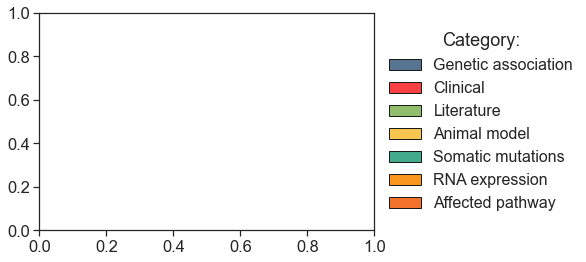

In [115]:
# timestamps legend
legend_elements = []
for source, color in {'Genetic association': '#577590',
 'Clinical': '#f94144',
 'Literature': '#90be6d',
 'Animal model': '#f9c74f',
 'Somatic mutations': '#43aa8b',
 'RNA expression': '#f8961e',
 'Affected pathway': '#f3722c',
 }.items():
    legend_elements.append(Patch(facecolor=color, edgecolor='k', label=source))

plt.figure()
fig, ax = plt.subplots()
ax.legend(
    handles=legend_elements,
    frameon=False,
    fontsize=plotTimeseries.font["size"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncols=1,
    title="Category:"
)
plt.savefig("../results/23.06/plots/legends.png", dpi=300, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

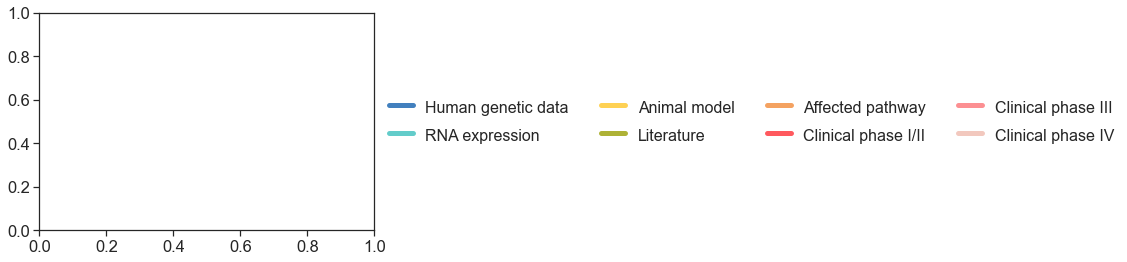

In [116]:
# bells legend
plt.rcParams['legend.handlelength'] = 1.5
plt.rcParams['legend.handleheight'] = 1.51
legend_elements = []
for source in ["Human genetic data","RNA expression", "Animal model","Literature","Affected pathway",
               "Clinical phase I/II","Clinical phase III","Clinical phase IV"]:
    legend_elements.append(
    Line2D(
        [0],
        [0],
        color=plotTimeseries.getDatatypeToColour(by="label")[source],
        lw=5,
        label=source,
    )    
    )
plt.figure()
fig, ax = plt.subplots()
ax.legend(
    handles=legend_elements,
    frameon=False,
    fontsize=plotTimeseries.font["size"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncols=4,
)
plt.savefig("../results/23.06/plots/legends.png", dpi=300, bbox_inches="tight")

In [ ]:
# therapy areas
plt.rcParams['legend.handlelength'] = .7
plt.rcParams['legend.handleheight'] = 1.51
#plt.rcParams['legend.numpoints'] = 1

tas = {idx: name for idx, name in plotTimeseries.getTherapeuticAreaToName().items() if name not in ('phenotype', 'injury, poisoning or other complication',"disorder of ear","hematologic disease","pregnancy or perinatal disease","psychiatric disorder")}
cmap_therapeuticAreas = dict(zip([tas[ta] for ta in sorted(tas, key=lambda x: tas[x])],
                                 list(sns.color_palette("tab20", len(tas)).as_hex())))
legend_elements = []
for source in sorted(cmap_therapeuticAreas):
    legend_elements.append(Patch(facecolor=cmap_therapeuticAreas[source], edgecolor='w', label=source.capitalize()))
plt.figure()
fig, ax = plt.subplots()
ax.legend(
    handles=legend_elements,
    frameon=False,
    fontsize=plotTimeseries.font["size"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncols=2,
)
plt.savefig("../results/23.06/plots/legends.png", dpi=300, bbox_inches="tight")

In [ ]:
# correlations legend
plt.rcParams['legend.handlelength'] = .9
plt.rcParams['legend.handleheight'] = 1.51
legend_elements = []
for source in ["Affected pathway", "Animal model", "Clinical","Genetic association", "Literature","RNA expression","Somatic mutations"]:
    legend_elements.append(Patch(facecolor=plotTimeseries.getDatatypeToColour(by="label")[source], edgecolor='w', label=source))

plt.figure()
fig, ax = plt.subplots()
ax.legend(
    handles=legend_elements,
    frameon=False,
    fontsize=plotTimeseries.font["size"],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncols=1,
    title="Category:"
)
plt.savefig("../results/23.06/plots/legends.png", dpi=300, bbox_inches="tight")

Novels

In [ ]:
# novels heatmap
red = "#e40a36"
orange = "#ebb871"
green = "#44952a"

novels = pd.read_csv("/Users/mariaf/TargetEngine/results/23.06/novels/novels.csv").sort_values(["Therapeutic area","association"], ascending=[False, False]).set_index("association").T[::-1].T
repurposed = pd.read_csv("/Users/mariaf/TargetEngine/results/23.06/novels/repurposed.csv").sort_values(["Therapeutic area","association"], ascending=[False, False]).set_index("association").T[::-1].T
novels = pd.concat([repurposed,novels]).sort_values(["Therapeutic area","association"]).dropna(axis="columns", how="all")
#set1 = novels.head(50)#.dropna(axis="columns", how="all")
#set2 = novels.tail(50)#.dropna(axis="columns", how="all")

#for novels in (set1, set2):
if 1:
    drugs = novels[["Indication therapeutic area", "Drug"]]
    novels = (novels[["Therapeutic area"]+sorted([col for col in novels.columns if "novelty" in col])])
    novels = novels.rename(columns={col: col.replace(" novelty","") for col in novels.columns})

    data = novels.values.T

    cmap_datasources = LinearSegmentedColormap.from_list('cmap_datasources', ["white",'#2AAA69'], N=256)
    custom_colors = [(red, -1), (orange, 0), (green, 1)]
    cmap_target = ListedColormap([color for color, value in custom_colors], name='cmap_target')
    norm = plt.Normalize(min(value for color, value in custom_colors), max(value for color, value in custom_colors))
    tas = {idx: name for idx, name in plotTimeseries.getTherapeuticAreaToName().items() if name not in ('phenotype', 'injury, poisoning or other complication',"disorder of ear","hematologic disease","pregnancy or perinatal disease","psychiatric disorder")}
    cmap_therapeuticAreas = dict(zip([tas[ta] for ta in sorted(tas, key=lambda x: tas[x])],
                                    list(sns.color_palette("tab20", len(tas)).as_hex())))    
    cmap_therapeuticAreas[np.nan]="w"

    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(30,25))

    cell_radius = 0.4
    square_size = 0.8  # Size of the square cells
    edge_color = 'gray'  # Color for the edge line

    for j in range(data.shape[1]):  
        for i in range(data.shape[0]):   
            if 0:
                pass                
            # if "Association score" in novels.columns[i]:
            #     square = Rectangle((i - square_size / 2, j - square_size / 2), square_size, square_size,
            #                        color=cmap_datasources(data[i, j]), edgecolor=edge_color, linewidth=0.5)
            #     ax.add_patch(square)
            #     if data[i, j] == 0:
            #         square.set_edgecolor(edge_color)
            #         square.set_linewidth(0.5) 
            
            if "Therapeutic area" in novels.columns[i]:  
                square = Rectangle((i , j - square_size / 2), .3, square_size,
                                color=cmap_therapeuticAreas[data[i, j]], edgecolor=edge_color, linewidth=0.5)
                ax.add_patch(square)
                if data[i, j] == 0:
                    square.set_edgecolor(edge_color)
                    square.set_linewidth(0.5)
            # elif "Drug" in novels.columns[i]:  
            #     ax.annotate(data[i,j], (i,j))
            else: # "novelty" in novels.columns[i]:
                circle = Circle((i, j), cell_radius, color=cmap_datasources(data[i, j]))
                ax.add_patch(circle)
                if (data[i, j] == 0) or (np.isnan(data[i, j])):
                    circle.set_edgecolor(edge_color)
                    circle.set_linewidth(0.2)                 

    ax.annotate("Drug for\nrepurposing", (i+3.2,j+1), fontsize=17, va="bottom", ha="center", annotation_clip=False)
    for idx, (ta, drug) in enumerate(drugs.values):
        if drug != drug:            
            txt = ""
        else:
            txt = drug.capitalize()
        if ta in ("congential disorder", "cancer or benign tumor","pancreas disease","endocrine system disease","immune system disease"):
            txt_colour = "w"
        else:
            txt_colour = "k"
        ax.annotate(txt, (i+3.2,idx), fontsize=16, color=txt_colour, va="center", ha="center", bbox=dict(boxstyle='round,pad=.2', facecolor=cmap_therapeuticAreas[ta]), annotation_clip=False)
                
    ax.set_aspect('equal')
    ax.set_frame_on(False)
    ax.set_xlim(-0.5, data.shape[0] - 0.5)  
    ax.set_ylim(-0.5, data.shape[1] - 0.5)
    ax.set_yticks(np.arange(data.shape[1]))  
    ax.set_yticklabels(novels.index)  
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_xticklabels(novels.columns, rotation=50, ha="left")
    ax.xaxis.set_ticks_position('none')
    plt.savefig("../results/23.06/plots/novels.png", dpi=100, bbox_inches="tight")
    plt.show()


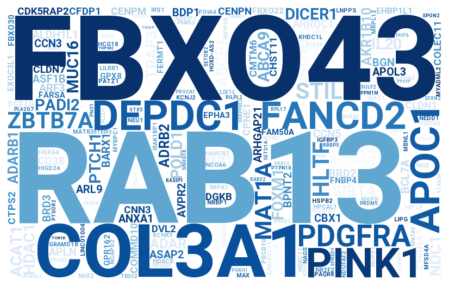

In [281]:
# wordclouds
data = (spark.read.parquet("../results/23.06/novels/novels0.4/year=2023")
        # .filter(~F.col("targetSymbol").isin(["CDCP1","TSPAN31","TMED3","NHIP","CASC20","DUSP5P1"]))
        .filter(~F.col("targetSymbol").isin(["TUFT1","CDCP1","BRCA1"]))
        #.filter(~F.col("therapeuticAreaName").isin(["reproductive system or breast disease","integumentary system disease"]))    
        .filter((F.col("datasources").contains("europepmc"))|(F.col("datasources").contains("ot_genetics_portal")))  
        .withColumn("metric", F.col("maxNovelty"))
        #.groupby("targetSymbol").agg(F.max("metric").alias("metric"))
        .orderBy("metric", ascending=False)
        #.limit(10)
        .withColumn("therapeuticAreaName", 
                    F.when(F.col("therapeuticAreaName")=="cancer or benign tumor", "Oncological diseases")
                    .otherwise(F.lit("Non-oncological diseases"))
        #             .when(F.col("therapeuticAreaName")=="psychiatric disorder", "Neuronal diseases")
        #             .when(F.col("therapeuticAreaName")=="musculoskeletal or connective tissue disease", "Musculoskeletal diseases")
        #             .otherwise("Other diseases")
         )
 ).toPandas()

target2score = dict(zip(data['targetSymbol'], data['metric']))

therapeuticAreaNames = sorted(data.datasources.unique())

def fixed_color_func(word, **kwargs):
    return "rgb(0, 0, 139)"  # Dark Blue


if 1:

    data_filtered=data
    
    # Create a dictionary of protein names and their corresponding scores
    target2score = dict(zip(data_filtered['targetSymbol'], data_filtered['metric']))
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=500, background_color='white', #color_func=blue_color_func,
                          font_path="/Library/Fonts/Roboto-Bold.ttf", 
                          colormap='Blues').generate_from_frequencies(target2score)
    
    # Plot the word cloud in the respective subplot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # No axis for word cloud display
    plt.savefig("../results/23.06/plots/wordclouds/all.png", dpi=500, bbox_inches="tight")

In [235]:
data=spark.read.parquet("../results/23.06/novels/novels0.4/year=2023").select("targetIds").distinct().withColumnRenamed("targetIds","targetId").join(
    spark.read.parquet("/Users/mariaf/OT_platform/23.06/targetsPriorisation")
    #.select("targetId", "hasSafetyEvent","maxClinicalTrialPhase","hasLigand","hasHighQualityChemicalProbes","hasPocket")
    ,
      "targetId", "left"
).fillna(0, subset=["maxClinicalTrialPhase","hasSafetyEvent"]).toPandas()

In [236]:
data

,targetId,isInMembrane,isSecreted,hasSafetyEvent,hasPocket,hasLigand,geneticConstraint,paralogMaxIdentityPercentage,mouseOrthologMaxIdentityPercentage,isCancerDriverGene,hasTEP,hasMouseKO,hasHighQualityChemicalProbes,maxClinicalTrialPhase,tissueSpecificity,tissueDistribution
0,ENSG00000182158,0.0,0.0,0,0.0,0.0,-0.309439,0.000000,0.557690,-1.0,NaN,1.0,NaN,0.0,-1.00,-1.0
1,ENSG00000120341,1.0,0.0,0,0.0,0.0,0.064388,0.000000,0.000000,NaN,NaN,1.0,NaN,0.0,0.50,0.0
2,ENSG00000138755,0.0,1.0,-1,0.0,0.0,0.746510,0.000000,0.000000,NaN,NaN,1.0,NaN,0.0,1.00,0.0
3,ENSG00000069011,0.0,0.0,0,0.0,0.0,-0.604501,-0.060510,0.840765,NaN,NaN,1.0,NaN,0.0,0.50,0.0
4,ENSG00000068831,1.0,0.0,0,0.0,0.0,-0.563763,0.000000,0.811165,NaN,NaN,1.0,NaN,0.0,0.50,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,ENSG00000166557,0.0,0.0,0,0.0,0.0,0.094186,-0.101383,0.493085,NaN,NaN,1.0,NaN,0.0,0.50,-1.0
1285,ENSG00000163812,0.0,0.0,0,0.0,0.0,-0.333507,-0.038462,0.163880,NaN,NaN,1.0,NaN,0.0,-1.00,-1.0
1286,ENSG00000126262,1.0,0.0,0,0.0,1.0,0.411023,0.000000,0.227275,NaN,NaN,1.0,1.0,0.5,0.50,0.0
1287,ENSG00000082438,0.0,0.0,0,0.0,0.0,-0.581684,0.000000,0.000000,NaN,NaN,NaN,NaN,0.0,0.50,-1.0


In [237]:
data.groupby("maxClinicalTrialPhase").count()/1289*100

,targetId,isInMembrane,isSecreted,hasSafetyEvent,hasPocket,hasLigand,geneticConstraint,paralogMaxIdentityPercentage,mouseOrthologMaxIdentityPercentage,isCancerDriverGene,hasTEP,hasMouseKO,hasHighQualityChemicalProbes,tissueSpecificity,tissueDistribution
maxClinicalTrialPhase,,,,,,,,,,,,,,,
0.00,76.027929,72.692009,72.692009,76.027929,73.312645,73.312645,72.381691,61.753297,70.674942,4.887510,0.310318,59.503491,4.577192,73.622964,73.622964
0.25,0.853375,0.853375,0.853375,0.853375,0.853375,0.853375,0.853375,0.698216,0.775795,0.155159,0.000000,0.853375,0.232739,0.853375,0.853375
0.50,3.801396,3.723817,3.723817,3.801396,3.723817,3.723817,3.723817,3.103181,3.646237,0.310318,0.000000,3.491078,1.163693,3.723817,3.723817
0.75,3.956555,3.956555,3.956555,3.956555,3.956555,3.956555,3.878976,3.180760,3.956555,0.155159,0.077580,3.723817,1.396431,3.878976,3.878976
1.00,15.360745,15.205586,15.205586,15.360745,15.205586,15.205586,15.050427,14.197052,14.895268,1.939488,0.077580,14.274631,7.059736,15.205586,15.205586


In [217]:
data.groupby("hasSafetyEvent").count()#/1289*100

,targetId,maxClinicalTrialPhase
hasSafetyEvent,,
-1,124,124
0,1165,1165


In [238]:
data.groupby("hasLigand").count()#/1289*100

,targetId,isInMembrane,isSecreted,hasSafetyEvent,hasPocket,geneticConstraint,paralogMaxIdentityPercentage,mouseOrthologMaxIdentityPercentage,isCancerDriverGene,hasTEP,hasMouseKO,hasHighQualityChemicalProbes,maxClinicalTrialPhase,tissueSpecificity,tissueDistribution
hasLigand,,,,,,,,,,,,,,,
0.0,874,862,862,874,874,858,714,841,45,4,702,11,874,870,870
1.0,377,374,374,377,377,372,349,364,51,2,344,174,377,375,375


In [231]:
data.groupby("hasPocket").count()#/1289*100

,targetId,hasSafetyEvent,maxClinicalTrialPhase,hasLigand,hasHighQualityChemicalProbes
hasPocket,,,,,
0.0,1102,1102,1102,1102,128
1.0,149,149,149,149,57


In [234]:
data.groupby("hasHighQualityChemicalProbes").count()/1289*100

,targetId,hasSafetyEvent,maxClinicalTrialPhase,hasLigand,hasPocket
hasHighQualityChemicalProbes,,,,,
0.0,5.042669,5.042669,5.042669,5.042669,5.042669
1.0,9.387122,9.387122,9.387122,9.309542,9.309542


In [295]:
# targets and associations found novel with different cutoffs
for cutoff in range(1,10)[::-1]:
    cutoff = cutoff/10
    associations = spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/novels/targets/novelty={}/year=2023".format(cutoff)).toPandas().sum().targets
    print(cutoff, associations)

0.9 0
0.8 6
0.7 24
0.6 73
0.5 828
0.4 1289
0.3 1752
0.2 2378
0.1 3837


In [ ]:
# bar chart: targetsByTherapeuticAreaName
data = (spark.read.parquet("../results/23.06/novels/targetsByTherapeuticAreaName0.4")
 .withColumnRenamed("novelty","targets")
 .replace({"cancer or benign tumor":"Oncological diseases",
           'nervous system disease':"Neuronal diseases",
           'musculoskeletal or connective tissue disease':"Musculoskeletal diseases",
           "genetic, familial or congenital disease":"Genetic diseases",
           "respiratory or thoracic disease":"Respiratory diseases",
           'integumentary system disease':"Integumentary diseases",
           'immune system disease':"Immune diseases",
           'reproductive system or breast disease':"Reproductive diseases",
           'nutritional or metabolic disease':"Metabolic diseases",
           'disorder of visual system':"Visual diseases",
           'urinary system disease':"Urinary diseases",
           "infectious disease":"Infectious diseases",
           "pancreas disease":"Pancreas diseases",
           "gastrointestinal disease":"Gastrointestinal diseases",
           "cardiovascular disease":"Cardiovascular diseases",
           })
 .orderBy("targets", ascending=False)
  .limit(15)
 ).toPandas()


plt.figure(figsize=(5,5)) 
ax = sns.barplot(data=data, x="therapeuticAreaName", y="targets", color=plotTimeseries.getDatatypeToColour()["genetic_association"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_xlabel("")
ax.set_ylabel("Unique targets\nwith novelty signal")
ax.set_title("Therapeutic area")
sns.despine()
plt.savefig("../results/23.06/plots/targetsByTherapeuticAreaName.png", dpi=300, bbox_inches="tight")

In [ ]:
# bar chart: targetsByDatasource
data = (spark.read.parquet("../results/23.06/novels/targetsByDatasource0.4")
 .withColumnRenamed("novelty","targets")
 .orderBy("targets", ascending=False)
  .limit(15)
 ).toPandas()

data["datatypeId"] = data.apply(lambda row: plotTimeseries.getDatatypeForDatasource(output="dict")[row.datasourceId], axis=1)
data = data.replace(plotTimeseries.getDatasourceToName(output="dict"))

fig = plt.figure(figsize=(5,5)) 
#fig.set_facecolor('w')
ax = sns.barplot(data=data, x="datasourceId", y="targets", hue="datatypeId", palette=plotTimeseries.getDatatypeToColour(), legend=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_xlabel("")
ax.set_ylabel("Unique targets\nwith novelty signal")
ax.set_title("Novelty source")
sns.despine()
plt.savefig("../results/23.06/plots/targetsBySource.png", dpi=300, bbox_inches="tight")

In [ ]:
# bar chart: targetsByDatatype
data = (spark.read.parquet("../results/23.06/novels/targetsByDatatype0.4")
 .orderBy("targets", ascending=False)
  .limit(15)
 ).toPandas()

data = data.replace(plotTimeseries.getDatasourceToName(output="dict"))

fig = plt.figure(figsize=(5,5)) 
#fig.set_facecolor('w')
ax = sns.barplot(data=data, x="datatypeId", y="targets", hue="datatypeId", legend=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_xlabel("")
ax.set_ylabel("Unique targets\nwith novelty signal")
ax.set_title("Novelty source")
sns.despine()
#plt.savefig("../results/23.06/plots/targetsBySource.png", dpi=300, bbox_inches="tight")

In [167]:
data = (spark.read.parquet("../results/23.06/novels/associations0.4/year=2023").orderBy("associations")
 ).toPandas()
data

,therapeuticAreaName,associations,year
0,hematologic disease,6,2023
1,pregnancy or perinatal disease,10,2023
2,endocrine system disease,10,2023
3,pancreas disease,11,2023
4,nutritional or metabolic disease,16,2023
5,integumentary system disease,25,2023
6,immune system disease,27,2023
7,urinary system disease,40,2023
8,"genetic, familial or congenital disease",40,2023
9,respiratory or thoracic disease,40,2023


In [82]:
spark.read.parquet("../results/23.06/novels/targetsByBiotype0.4").show()

+--------------------+-------+----+
|       targetBiotype|targets|year|
+--------------------+-------+----+
|              lncRNA|     20|2023|
|  unitary_pseudogene|      1|2023|
|      protein_coding|   1259|2023|
|            ribozyme|      1|2023|
|           TR_V_gene|      1|2023|
|transcribed_unita...|      1|2023|
|unprocessed_pseud...|      1|2023|
|             Mt_tRNA|      2|2023|
|           TR_D_gene|      1|2023|
|processed_pseudogene|      2|2023|
+--------------------+-------+----+



In [73]:
spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/novels/counts0.4/year=2021").toPandas().groupby(["datasourceId"]).sum().sort_values("associations")

,therapeuticAreaName,targets,associations
datasourceId,,,
uniprot_literature,musculoskeletal or connective tissue disease,1,1
uniprot_variants,nervous system disease,1,1
genomics_england,disorder of visual systemendocrine system dise...,20,22
gene2phenotype,cardiovascular diseasedisorder of visual syste...,24,25
reactome,infectious disease,39,39
eva_somatic,cancer or benign tumorcardiovascular diseasedi...,51,65
orphanet,cardiovascular diseasedisorder of visual syste...,81,90
cancer_gene_census,cancer or benign tumorhematologic disease,189,237
clingen,cancer or benign tumorcardiovascular diseasedi...,260,276


In [63]:
spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/novels/associationsByArea0.4/year=2023").toPandas().sum()

therapeuticAreaName    cancer or benign tumorother
associations                                  1574
year                                          4046
dtype: object

In [241]:
data = (spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/novels/counts0.4/year=2023")
        .drop("targets")
        #.filter(F.col("associations")>10)
 .replace({k:v+" diseases" for k, v in {"cancer or benign tumor":"Oncological",
           'nervous system disease':"Neuronal",
           'musculoskeletal or connective tissue disease':"Musculoskeletal",
           "genetic, familial or congenital disease":"Genetic",
           "respiratory or thoracic disease":"Respiratory",
           'integumentary system disease':"Integumentary",
           'immune system disease':"Immune",
           'reproductive system or breast disease':"Reproductive",
           'nutritional or metabolic disease':"Metabolic",
           'disorder of visual system':"Visual",
           'urinary system disease':"Urinary",
           "infectious disease":"Infectious",
           "pancreas disease":"Pancreas",
           "gastrointestinal disease":"Gastrointestinal",
           "cardiovascular disease":"Cardiovascular",
           "hematologic disease":"Hematologic",
           "pregnancy or perinatal disease":"Pegnancy",
           "psychiatric disorder":"Psyciatric",
           "endocrine system disease":"Endocrine",
           "disorder of ear":"Ear"
           }.items()})
 .orderBy("therapeuticAreaName","datasourceId")
 .drop("targets")
 ).toPandas().replace(plotTimeseries.getDatasourceToName(output="dict")).pivot(index="therapeuticAreaName", columns="datasourceId", values="associations")

In [247]:
data.T.sum()

therapeuticAreaName
Cardiovascular diseases       82.0
Endocrine diseases            10.0
Gastrointestinal diseases     52.0
Genetic diseases              40.0
Hematologic diseases           6.0
Immune diseases               27.0
Infectious diseases           69.0
Integumentary diseases        25.0
Metabolic diseases            16.0
Musculoskeletal diseases      70.0
Neuronal diseases            147.0
Oncological diseases         861.0
Pancreas diseases             11.0
Pegnancy diseases             10.0
Respiratory diseases          40.0
Urinary diseases              40.0
Visual diseases               68.0
dtype: float64

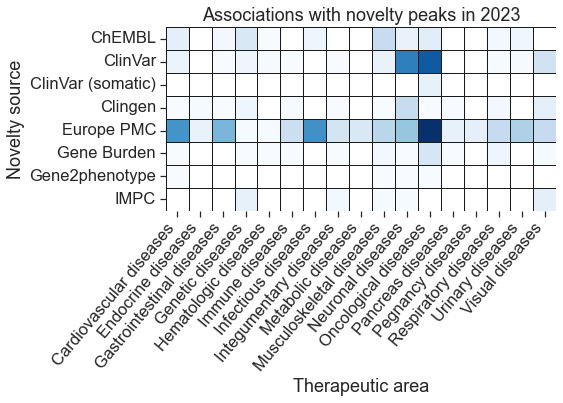

In [245]:
plt.figure(figsize=(7,7))
ax = sns.heatmap(data.T, cmap="Blues", lw=1, vmax=100, linecolor="k", square=True, cbar=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
ax.set_title("Associations with novelty peaks in 2023")
ax.set_ylabel("Novelty source")
ax.set_xlabel("Therapeutic area")
plt.savefig("../results/23.06/plots/novels2023.png", bbox_inches="tight", dpi=300)

24/11/06 14:30:18 WARN DataSource: Found duplicate column(s) in the data schema and the partition schema: `year`
24/11/06 14:30:18 WARN DataSource: Found duplicate column(s) in the data schema and the partition schema: `year`


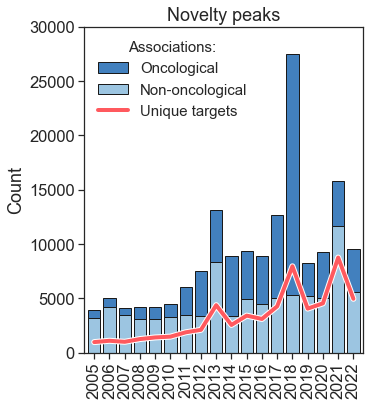

In [76]:
data = (spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/novels/associationsByArea0.4")
        .filter(F.col("year")>=2005)
        .filter(F.col("year")<2023)
        .orderBy("year").replace("therapeuticAreaName","Oncological").replace("other","Non-oncological").toPandas()
        .pivot(index="year", columns="therapeuticAreaName", values="associations")
        
)

fig = plt.figure(figsize=(5,6))
ax = fig.add_subplot()
data.plot(kind='bar', stacked=True, width=.8, color=["#9CC5E1","#4280BE"], lw=1, edgecolor="k", ax=ax)
data = spark.read.parquet("/Users/mariaf/TargetEngine/results/23.06/novels/targets0.4").filter(F.col("year")>=2005).filter(F.col("year")<2023).orderBy("year").toPandas()
data[["targets"]].plot(kind="line", color="w", lw=6, ax=ax)
data[["targets"]].plot(kind="line", color="#FF595E", lw=4, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Novelty peaks")
ax.set_xlabel("")
ax.set_ylim(0,30000)
ax.set_ylabel("Count")

ax.legend(
    handles=[Patch(facecolor="#4280BE", edgecolor='k', label="Oncological"), Patch(facecolor="#9CC5E1", edgecolor='k', label="Non-oncological"), Line2D([0], [0], color="#FF595E", lw=4, label="Unique targets")],
    frameon=False,
    title_fontsize=15,
    fontsize=15,
    loc="upper left",
    #bbox_to_anchor=(1, 0.5),
    ncols=1,
    title="Associations:"
)
plt.savefig("../results/23.06/plots/novels.png", dpi=300, bbox_inches="tight")

Extras

In [ ]:
# year difference for evidence with several timestamps
spark.read.parquet("../results/23.06/evidenceDated").select("publicationYear","curationYear","datasourceId").filter(F.col("publicationYear").isNotNull()&F.col("curationYear").isNotNull()).withColumn("window",F.col("curationYear")-F.col("publicationYear")).toPandas().groupby("datasourceId").median()